In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

Load dataset

In [13]:
train_dataset = h5py.File('../Datasets/mps_gp_sgram/ml_data_CNN/all_dsMPS_data.h5', "r")
print(train_dataset)

train_set_x_orig = np.array(train_dataset["data_dsMPS_x"][:]) # your train set features
train_set_y_orig = to_categorical(np.ravel(np.array(train_dataset["data_label_y"][:]))) # your train set labels

# train_set_x_norm= train_set_x_orig
# nsamples, nx, ny = train_set_x_orig.shape
# standard_scaler = StandardScaler()
# standard_scaler.fit(train_set_x_orig.reshape((nsamples,nx*ny)))
# train_set_x_norm = standard_scaler.transform(train_set_x_orig)

X_train, X_test, y_train, y_test = train_test_split(train_set_x_orig, train_set_y_orig,test_size=0.25, random_state=1)
print(f"Type: X_train={type(X_train)}, y_train={type(y_train)}")
print(f"Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")

unq_vals, unq_counts = np.unique(y_train, return_counts=True)
print(dict(zip(unq_vals,unq_counts)))
# print(X_train)


<HDF5 file "all_dsMPS_data.h5" (mode r)>
Type: X_train=<class 'numpy.ndarray'>, y_train=<class 'numpy.ndarray'>
Shapes: X_train=(1203, 80, 69), y_train=(1203, 5), X_test=(402, 80, 69), y_test=(402, 5)
{0.0: 4812, 1.0: 1203}


Train a fully connected NN followed by a softmax

In [19]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
CNNmodel = tf.keras.Sequential([
    ## ZeroPadding2D with padding 3, input shape of 80 x 69 x 1
    ## Conv2D with 32 5x5 filters and stride of 1
    ## BatchNormalization for axis 3
    ## ReLU
    ## Max Pooling 2D with default parameters
    ## Flatten layer
    ## Dense layer with 1 unit for output & 'sigmoid' activation            
        
    # YOUR CODE STARTS HERE
    tf.keras.layers.ZeroPadding2D(padding=3,input_shape=(80,69,1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=5, activation='softmax'),
    # YOUR CODE ENDS HERE
    ])

CNNmodel.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
CNNmodel.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_3 (ZeroPaddi  (None, 86, 75, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 86, 75, 16)        416       
                                                                 
 batch_normalization_3 (Batc  (None, 86, 75, 16)       64        
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 86, 75, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 37, 16)       0         
 2D)                                                             
                                                      

Train the model

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
history = CNNmodel.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
38/38 [==============================] - 1s 11ms/step - loss: 3.9278 - accuracy: 0.4771 - val_loss: 24.6760 - val_accuracy: 0.1045
Epoch 2/100
38/38 [==============================] - 0s 7ms/step - loss: 0.5253 - accuracy: 0.8196 - val_loss: 10.7873 - val_accuracy: 0.1866
Epoch 3/100
38/38 [==============================] - 0s 7ms/step - loss: 0.3111 - accuracy: 0.8986 - val_loss: 6.2169 - val_accuracy: 0.3905
Epoch 4/100
38/38 [==============================] - 0s 7ms/step - loss: 0.2385 - accuracy: 0.9368 - val_loss: 3.6188 - val_accuracy: 0.4527
Epoch 5/100
38/38 [==============================] - 0s 7ms/step - loss: 0.1952 - accuracy: 0.9568 - val_loss: 3.5650 - val_accuracy: 0.3532
Epoch 6/100
38/38 [==============================] - 0s 7ms/step - loss: 0.1764 - accuracy: 0.9593 - val_loss: 2.0479 - val_accuracy: 0.4776
Epoch 7/100
38/38 [==============================] - 0s 7ms/step - loss: 0.1520 - accuracy: 0.9543 - val_loss: 0.6028 - val_accuracy: 0.7438
Epoch 8/10

Check output of NN model 

13/13 [==============================] - 0s 2ms/step
Unique values in y_train_pred_NN=[0 1 2 3 4]
Unique values in y_test_pred_NN=[0 1 2 3 4]
Training accuracy=1.0
 Testing accuracy=0.9402985074626866



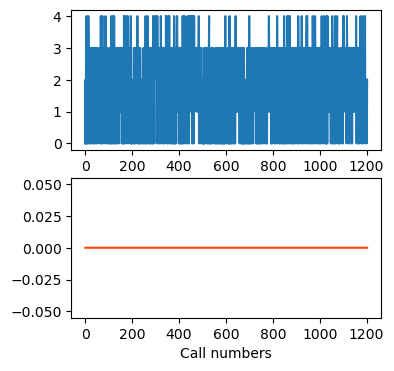

In [21]:
y_train_pred_NN = np.argmax(CNNmodel.predict(X_train), axis=1)
y_test_pred_NN = np.argmax(CNNmodel.predict(X_test), axis=1)
y_train_numeric= np.argmax(y_train, axis=1)
y_test_numeric= np.argmax(y_test, axis=1)

print(f"Unique values in y_train_pred_NN={np.unique(y_train_pred_NN)}")
print(f"Unique values in y_test_pred_NN={np.unique(y_test_pred_NN)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_numeric)
ax[1].plot(y_train_numeric-y_train_pred_NN, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={np.sum(y_train_numeric==y_train_pred_NN)/len(y_train)}\n Testing accuracy={np.sum(y_test_numeric==y_test_pred_NN)/len(y_test_numeric)}\n")